## Denoising





Pour ce projet vous avez :

Pour le train
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers.

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires.

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai.

L'objectif est d'estimer à partir du signal bruité le signal de voix.

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB.

Vous pouvez au choix travailler
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 09 et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  :
   - cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
   - les apporches TAS NEt : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la fonction de perte utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones.

Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.  


In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir denoising
!unzip drive/MyDrive/MVA/DeepSignal/denoising/test.zip -d denoising > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/denoising/train.zip -d denoising > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/denoising/train_small.zip -d denoising > /dev/null 2>&1
!mkdir voice_origin
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/test.zip -d voice_origin > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/train.zip -d voice_origin > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/train_small.zip -d voice_origin > /dev/null 2>&1

In [3]:
path = "/"

In [4]:
!pip install pySTOI
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262919 sha256=8352f6e15f5f9792c75159838c6999608a741317f80e24e97279ec4ded1b4dba
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [5]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile
from scipy.io import wavfile
from pystoi import stoi
from pesq import pesq
import soundfile as sf

## Visualisation

In [6]:
rate, data = scipy.io.wavfile.read('denoising/train/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav')
ipd.Audio(data, rate=rate)

## Data

In [73]:
def normalize_waveform(waveform):
    # Normalize the waveform in the range [-1, 1]
    return waveform / np.max(np.abs(waveform))

class AudioDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, n_splits):
        self.noisy_files = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.wav')]
        self.clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.wav')]
        assert len(self.noisy_files) == len(self.clean_files), "Mismatch in dataset size"
        self.n_splits = n_splits

    def __len__(self):
        return len(self.noisy_files) * self.n_splits

    def __getitem__(self, idx):
        original_idx = idx // self.n_splits
        split_idx = idx % self.n_splits

        noisy_rate, noisy_waveform = wavfile.read(self.noisy_files[original_idx])
        clean_rate, clean_waveform = wavfile.read(self.clean_files[original_idx])

        waveform_length = len(noisy_waveform)
        split_length = waveform_length // self.n_splits
        start_idx = split_length * split_idx
        end_idx = start_idx + split_length

        noisy_split = noisy_waveform[start_idx:end_idx]
        clean_split = clean_waveform[start_idx:end_idx]

        # Convert clean waveform to float32
        clean_split = clean_split.astype(np.float32)
        noisy_split = noisy_split.astype(np.float32)

        noisy_split = normalize_waveform(noisy_split)
        clean_split = normalize_waveform(clean_split)

        return noisy_split, clean_split

In [74]:
train_dataset = AudioDenoisingDataset('denoising/train/', 'voice_origin/train/', 1)
test_dataset = AudioDenoisingDataset('denoising/test/', 'voice_origin/test/', 1)

In [75]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Batch 0:
  Input shape: torch.Size([8, 80000])
  Label shape: torch.Size([8, 80000])


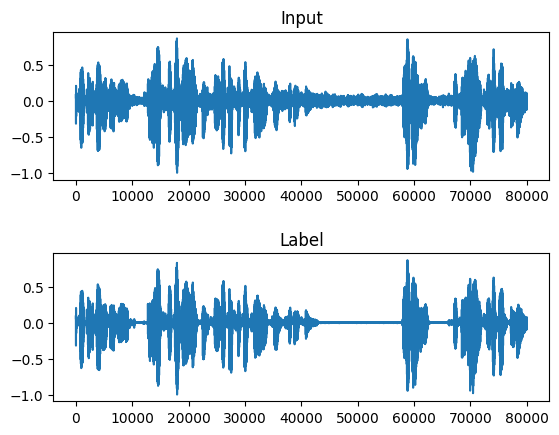

In [89]:
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print("  Input shape:", inputs.shape)
    print("  Label shape:", labels.shape)
    plt.figure()
    plt.subplot(211)
    plt.title("Input")
    plt.plot(inputs[0, :])
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(212)
    plt.title("Label")
    plt.plot(labels[0, :])
    plt.show()
    if i == 0:  # Just to check the first batch as an example
        break

## Models

In [77]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder (contracting path)
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder (expansive path)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2)
        )

        # Output layer
        self.outconv = nn.Conv1d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.bottleneck(x1)
        x3 = self.decoder(x2)
        output = self.outconv(x3)
        return output

# Create the U-Net model
model = UNet()
print(model)


UNet(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(64, 64, kern

## Pipelines

In [78]:
def train(model, train_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)  # Move to device and ensure the data type matches the model

        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss

In [79]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No need to track the gradients
        for batch in val_loader:
            inputs, targets = batch

            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    average_loss = total_loss / len(val_loader)
    return average_loss

## Training

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming unet_model is your U-Net model
model = UNet().to(device)

# Choose an appropriate loss function
criterion = nn.MSELoss()  # Example for a regression task like denoising

# Select an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [81]:
epochs = 10  # Number of epochs
best_val_loss = float('inf')  # InitA. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 ialize best validation loss as infinity

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")
    # Save the model if the validation loss improved
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.8f} to {val_loss:.8f}. Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_denoise_unet.pt')

Epoch 1/10 - Training Loss: 0.00292766, Validation Loss: 0.00187430
Validation loss improved from inf to 0.00187430. Saving model...
Epoch 2/10 - Training Loss: 0.00126215, Validation Loss: 0.00124465
Validation loss improved from 0.00187430 to 0.00124465. Saving model...
Epoch 3/10 - Training Loss: 0.00116428, Validation Loss: 0.00114346
Validation loss improved from 0.00124465 to 0.00114346. Saving model...
Epoch 4/10 - Training Loss: 0.00108837, Validation Loss: 0.00105317
Validation loss improved from 0.00114346 to 0.00105317. Saving model...
Epoch 5/10 - Training Loss: 0.00103072, Validation Loss: 0.00095456
Validation loss improved from 0.00105317 to 0.00095456. Saving model...
Epoch 6/10 - Training Loss: 0.00097811, Validation Loss: 0.00099195
Epoch 7/10 - Training Loss: 0.00097446, Validation Loss: 0.00092420
Validation loss improved from 0.00095456 to 0.00092420. Saving model...
Epoch 8/10 - Training Loss: 0.00096165, Validation Loss: 0.00095251
Epoch 9/10 - Training Loss: 0.0

# Results

In [82]:
model = UNet().to(device)
model.load_state_dict(torch.load('best_denoise_unet.pt'))

<All keys matched successfully>

In [83]:
stoi_originals,stoi_preds, pesq_originals, pesq_preds = [], [], [], []
stop = 150
for i, (input, target) in enumerate(test_dataset):
    if i==stop:
        break
    input = torch.from_numpy(input).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(input)
        prediction = prediction.squeeze(0).squeeze(0).cpu().numpy()
        input = input.squeeze(0).squeeze(0).cpu().numpy()

        stoi_originals.append(stoi(target, input, rate))
        stoi_preds.append(stoi(target, prediction, rate))
        pesq_preds.append(pesq(rate, target, prediction, 'nb'))
        pesq_originals.append(pesq(rate, target, input, 'nb'))
stoi_diffs = [a - b for a, b in zip(stoi_preds, stoi_originals)]  # >0 is better
pesq_diffs = [a - b for a, b in zip(pesq_preds, pesq_originals)]  # >0 is better

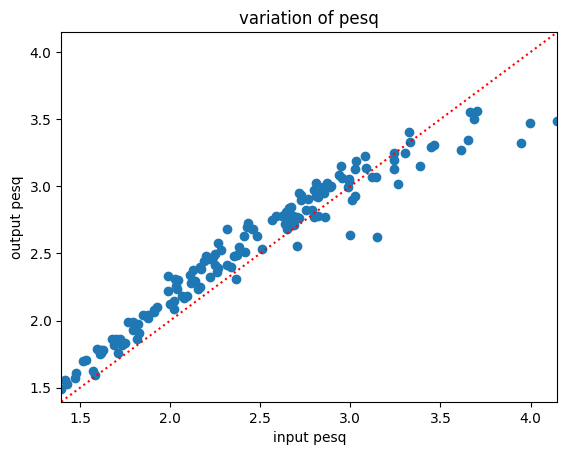

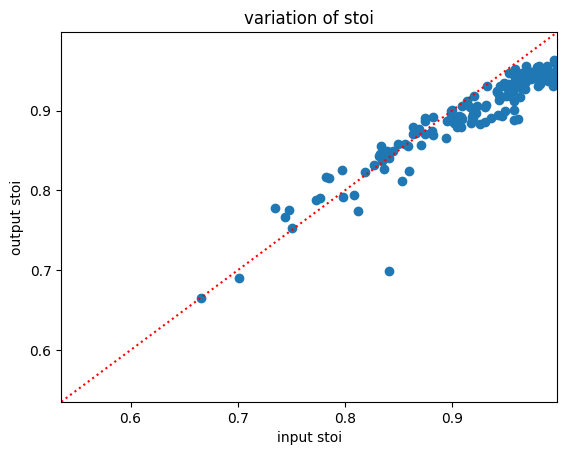

In [95]:
plt.title("variation of pesq")
plt.scatter(pesq_originals, pesq_preds)
plt.xlim(np.min(pesq_originals), np.max(pesq_originals))
plt.ylim(np.min(pesq_originals),np.max(pesq_originals))
plt.plot([min(pesq_originals), max(pesq_originals)], [min(pesq_originals), max(pesq_originals)], color='red', linestyle=':', label='Identity Line')
plt.xlabel("input pesq")
plt.ylabel("output pesq")
plt.show()

plt.title("variation of stoi")
plt.scatter(stoi_originals, stoi_preds)
plt.xlim(np.min(stoi_originals), np.max(stoi_originals))
plt.ylim(np.min(stoi_originals),np.max(stoi_originals))
plt.plot([min(stoi_originals), max(stoi_originals)], [min(stoi_originals), max(stoi_originals)], color='red', linestyle=':', label='Identity Line')
plt.xlabel("input stoi")
plt.ylabel("output stoi")
plt.show()

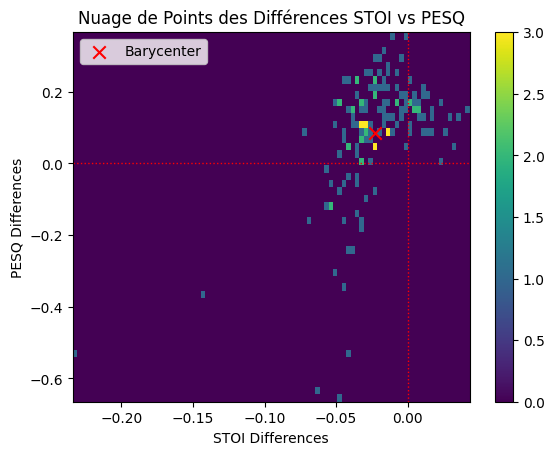

barycentre coordinates:
	STOI_diffs: -0.022997352960425498 
	PESQ_diffs: 0.08417307138442993


In [93]:
plt.hist2d(stoi_diffs, pesq_diffs, bins=(90, 50), cmap='viridis')

# Add colorbar
plt.colorbar()
# Set labels and title
plt.xlabel('STOI Differences')
plt.ylabel('PESQ Differences')
plt.title('Nuage de Points des Différences STOI vs PESQ')
plt.axhline(0, color='red', linestyle=':', linewidth=1)
plt.axvline(0, color='red', linestyle=':', linewidth=1)
plt.scatter(np.mean(stoi_diffs), np.mean(pesq_diffs), c='red', marker='x', label='Barycenter', s=80)
plt.legend()
# Show the plot
plt.show()
print("barycentre coordinates:\n\tSTOI_diffs:", np.mean(stoi_diffs) , "\n\tPESQ_diffs:", np.mean(pesq_diffs))

## Vizualize result for one sample & Analysis

In [86]:
example_file = "Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_100_.wav"
rate, data_example = scipy.io.wavfile.read('/content/denoising/test/'+example_file)
print("INPUT")
ipd.Audio(data_example, rate=rate)

INPUT


In [87]:
print("PREDICTION")
res_example = model(torch.from_numpy(data_example).unsqueeze(0).to(device))
ipd.Audio(res_example.cpu().detach().numpy(), rate=rate)

PREDICTION


In [88]:
print("TARGET")
rate, target_example = scipy.io.wavfile.read('/content/voice_origin/test/'+example_file)
ipd.Audio(target_example, rate=rate)

TARGET


## Notes
Nous avons également réalisé de la data augmentation sur le dataset utilisé en divisant chaque échantillons de 10 secondes en 2 échantillons de 5 secondes, voici les résultats obtenus:

| Nombre de split | PESQ |
|-----------|-----------|
| 0   | 0.084    |
| 1   | 0.083    |

Les résultats obtenus nous montrent que la data augmentation par division d'échantillons ne permet pas d'avoir de meilleurs résultats